# Clustering analysis

There are two datasets that have similar information for France and South Korea, respectively. So, the idea is to merge those datasets and see if we can find clusters. 

You can find the links to the data here: 
- France: https://www.kaggle.com/lperez/coronavirus-france-dataset
- South Korea: https://www.kaggle.com/kimjihoo/coronavirusdataset

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
import geopandas
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

## Load the data and check missing values
Let's load the data for both datasets and see how many NAs values it has. NAs values correspond to missing or empty information. Decisions should be made for each particular column to prepare the data for the analysis. 

In [2]:
def load_data(data_path):
    df = pd.read_csv(data_path + '/patient.csv')
    df['released_date'] = pd.to_datetime(df['released_date'])
    df['confirmed_date'] = pd.to_datetime(df['confirmed_date'])
    df['month'] = df['confirmed_date'].dt.month
    df['day'] = df['confirmed_date'].dt.day
    return df

In [3]:
df_france = load_data('coronavirusdataset_france')
df_france.isnull().sum()

id                  2067
sex                 1851
birth_year          1936
country                1
region                 1
departement          195
city                1804
group               1905
infection_reason    1906
infection_order     2068
infected_by         2056
contact_number      2073
confirmed_date         4
released_date       2064
deceased_date       2048
status              1481
health              1849
source               199
comments            1637
month                  4
day                    4
dtype: int64

In [4]:
df_south_korea = load_data('coronavirusdataset_south_korea')
df_south_korea.isnull().sum()

patient_id             0
sex                 7190
birth_year          7203
country                0
region              7432
disease             7841
group               7783
infection_reason    7715
infection_order     7833
infected_by         7799
contact_number      7816
confirmed_date         0
released_date       7813
deceased_date       7833
state                  0
month                  0
day                    0
dtype: int64

## Resolve missing values

- With the objective of keeping the necessary data, some of the columns are removed such as department, comments, health considered not important for the analysis. 
- From the birth date, we can create the age variable, subtracting it to the actual date. The missing information will be filled with random numbers drawn from a distribution. The information related to the age distribution of the population can be found:     
 *France:* https://www.indexmundi.com/france/demographics_profile.html  
 *South Korea:* https://www.indexmundi.com/south_korea/demographics_profile.html
 
So, the 'simulate_age' function is created in order to simulate the population's age based on the available data. 
 

In [5]:
df_france.drop(['departement','region','comments', 'id', 'infected_by','health','city','source'],axis=1,inplace=True)
df_south_korea.drop(['region','disease','patient_id','infected_by'], axis=1, inplace=True)

In [6]:
def simulate_age(ranges, percents, total_pop):
    simulated_pop = np.array(0)
    for (low, high), percent in zip(ranges, percents):
        simulated_pop = np.append(simulated_pop, 
                  np.random.randint(low=low, high=high, size=int(total_pop*percent/100)))
    return simulated_pop

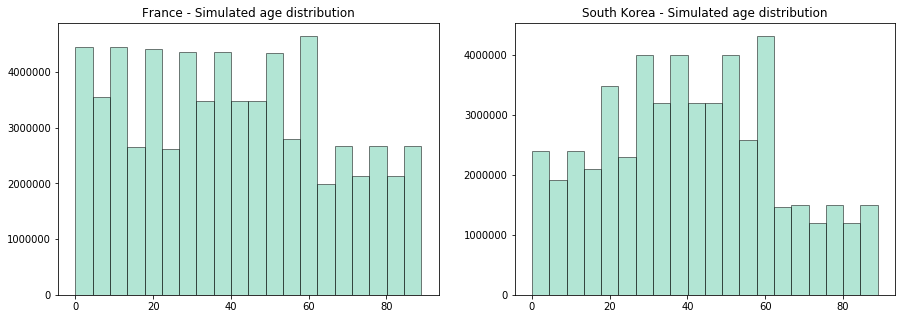

In [7]:
#France
france_population = 67364357

'''
0-14 years: 18.48% 
15-24 years: 11.8% 
25-54 years: 37.48% 
55-64 years: 12.42%
65 years and over: 19.82%
'''
ranges = [(0,14),(15,24),(25,54),(55,64),(65,90)]
percents = [18.48,11.8,37.48,12.42,19.82]
france_simulated_pop = simulate_age(ranges, percents, france_population)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.hist(france_simulated_pop,bins=20, color='mediumaquamarine', edgecolor='k', alpha=0.5)
ax1.set_title('France - Simulated age distribution')

#South Korea
south_korea_population = 51418097

'''
0-14 years: 13.03% 
15-24 years: 12.19%
25-54 years: 45.13%
55-64 years: 15.09% 
65 years and over: 14.55% 
'''
percents = [13.03,12.19,45.13,15.09,14.55]
south_korea_simulated_pop = simulate_age(ranges, percents, south_korea_population)

ax2.hist(south_korea_simulated_pop,bins=20, color='mediumaquamarine', edgecolor='k', alpha=0.5)
ax2.set_title('South Korea - Simulated age distribution')
plt.show()

Now, let's create the age column, and fill the missing values with a random value chosen from the distributions that we just simulated.

In [8]:
import math
actual_year = pd.to_datetime('today').year
def calculate_age(x):
    if math.isnan(x):
        return x
    else:
        return int(actual_year - x)

#France
df_france['age'] = df_france['birth_year'].apply(calculate_age)
df_france.fillna({'age':int(random.choice(france_simulated_pop))}, inplace=True)
df_france.drop(['birth_year'], axis=1, inplace=True)

#South Korea
df_south_korea['age'] = df_south_korea['birth_year'].apply(calculate_age)
df_south_korea.fillna({'age':int(random.choice(south_korea_simulated_pop))}, inplace=True)
df_south_korea.drop(['birth_year'], axis=1, inplace=True)

For sex missing values, we can draw a random number with a value of probability based on the sex ratio for each population.

In [9]:

'''
Considering m as men and w as women. 
m/w=ratio -> m=ration*w
m+w=total_pop
-> ratio*w +w=total_pop -> (ratio+1)*w=total_pop -> w=total_pop/(ratio+1)
we should divide w by the total in order to get the probability of being women 
'''
def calculate_values(ratio, total_pop):
    w = (france_population/(1+ratio))/total_pop
    m = 1 - w
    return (w,m)


# France
# total population: 0.96 male(s)/female (2018 est.)
w,m = calculate_values(0.96, france_population)
#choice among 0 (woman) and 1 (man) with the calculated probabilities
df_france['sex'] = df_france['sex'].str.lower()
df_france["sex"].replace({"male\xa0?": "male"}, inplace=True)
df_france.fillna({'sex': np.random.choice(['female','male'],p=[w,m])}, inplace=True)

# South Korea
# total population: 1 male(s)/female (2018 est.)
w,m = calculate_values(1, south_korea_population)
df_south_korea['sex'] = df_south_korea['sex'].str.lower()
df_south_korea["sex"].replace({"male\xa0?": "male"}, inplace=True)
df_south_korea.fillna({'sex': np.random.choice(['female','male'],p=[w,m])}, inplace=True)

Since the status column for France's dataset and the state column for South Korea's dataset have the same meaning, we can rename the column for one of the datasets, and update the values to be the same categories.

In [10]:
df_france.rename({'status':'state'}, axis=1, inplace=True)
df_france['state'] = df_france['state'].apply(lambda x: 'isolated' if (x=='hospital' or x=='home isolation') else x)

- The values for the country variable that are empty will be filled with France or South Korea, respectively.
- A new category 'Unknown' will be created for infection_reason, group, status variables
- A new category for infection_order is added with code 0 
- The empty values for contact number will be filled with 0 

In [11]:
df_france.fillna({'country':'France','infection_reason':'Unkown','group':'Unkown', 
                  'state':'Unknown','infection_order':0, 'contact_number':0} ,
                 inplace=True)

df_south_korea.fillna({'infection_reason':'Unkown','group':'Unkown', 
                       'infection_order':0, 'contact_number':0, 
                       'state':'Unknown'} ,
                 inplace=True)

Let's check now which are the missing values that still  need to be resolved.

In [12]:
df_france.isnull().sum()

sex                    0
country                0
group                  0
infection_reason       0
infection_order        0
contact_number         0
confirmed_date         4
released_date       2064
deceased_date       2048
state                  0
month                  4
day                    4
age                    0
dtype: int64

In [13]:
df_south_korea.isnull().sum()

sex                    0
country                0
group                  0
infection_reason       0
infection_order        0
contact_number         0
confirmed_date         0
released_date       7813
deceased_date       7833
state                  0
month                  0
day                    0
age                    0
dtype: int64

Nice!, we don't have too much left. 
Now we need to resolve released_date and deceased_date empty values. 
- If released_date is empty, it means that the person still has the virus. 
- If deceased_date is empty, it means that the person did not die. 

So, we can calculate the infection duration in days and remove the other 3 variables.  
And transform deceased_date to a binary column, indicated if the person died or not.

In [14]:
df_france['released_date'] = df_france[['released_date','deceased_date']].fillna(df_france['deceased_date'])
df_france['released_date'] = df_france[['released_date']].fillna(pd.to_datetime('today'))
df_france['infection_duration'] = pd.to_datetime(df_france['released_date']).sub(df_france['confirmed_date'], axis=0)
df_france = df_france[df_france['infection_duration'].dt.days>=0]
df_france['infection_duration'] = df_france['infection_duration'].dt.days
df_france.drop(['released_date','confirmed_date','deceased_date'], axis=1, inplace=True)

df_south_korea['released_date'] = df_south_korea[['released_date','deceased_date']].fillna(df_south_korea['deceased_date'])
df_south_korea['released_date'] = df_south_korea[['released_date']].fillna(pd.to_datetime('today'))
df_south_korea['infection_duration'] = pd.to_datetime(df_south_korea['released_date']).sub(df_south_korea['confirmed_date'], axis=0)
df_south_korea = df_south_korea[df_south_korea['infection_duration'].dt.days>=0]
df_south_korea['infection_duration'] = df_south_korea['infection_duration'].dt.days
df_south_korea.drop(['released_date','confirmed_date','deceased_date'], axis=1, inplace=True)

In [15]:
df_france.columns

Index(['sex', 'country', 'group', 'infection_reason', 'infection_order',
       'contact_number', 'state', 'month', 'day', 'age', 'infection_duration'],
      dtype='object')

In [16]:
df_south_korea.columns

Index(['sex', 'country', 'group', 'infection_reason', 'infection_order',
       'contact_number', 'state', 'month', 'day', 'age', 'infection_duration'],
      dtype='object')

## Data Fusion
Finally, we are ready to put the two datasets together and start our analysis.

In [17]:
df = df_france.append(df_south_korea, sort=False)

In [18]:
df.isnull().sum()

sex                   0
country               0
group                 0
infection_reason      0
infection_order       0
contact_number        0
state                 0
month                 0
day                   0
age                   0
infection_duration    0
dtype: int64

## Transform to dummies the categorical variables

In [19]:
df = pd.concat([df, pd.get_dummies(df['sex'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['country'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['state'], drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['infection_reason'], drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['group'], drop_first=True)], axis=1)

## Dimension reduction

Since we have too many variables, it is difficult to find the pattern among the clusters. 
So, first we can reduce the number of categorical variables by grouping similar categories. 
After, we can apply a dimension reduction technique to reduce the input variables and make the model easier to interpret. 

In [20]:
df = df_france.append(df_south_korea, sort=False)

Transform infection_reason: let's list the possible values for this variable, and group them. The, transform to dummy variables. Drop one since it is implicit from the others. 

In [21]:
df.infection_reason.unique()

array(['visit to Italy', 'contact with patient',
       'visit to Mulhouse religious gathering', 'Unkown',
       'contact with person who visited Italy', 'visit to Egypt',
       'unknown', 'visit to Oise', 'visit to Germany',
       'Visit to Venise, Italy', 'contact with patient in Auray',
       'visit to Mulhouse', 'visit to Milan', 'Italian',
       'visit to Lombardy', 'parishioner', 'Creil military base\xa0?',
       'visit to Senegal', 'visit to Alsace', 'visit in Lombardy',
       'visit to Bretagne', 'Visit in Italy',
       'In contact with someone contamitaminated in Oise',
       'Religious Meeting in Mulhouse', 'work in a medical environment ',
       'Visit family in Oise', 'health professional', 'visit to Wuhan',
       'contact with patient in Japan', 'residence in Wuhan',
       'visit to Thailand', 'contact with patient in Singapore',
       'visit to China', 'visit to Daegu', 'pilgrimage to Israel',
       'contact with patient in Daegu', 'visit to Vietnam',
      

In [22]:
def transform_reason(value):
    if ('religious' in value or 'parishioner' in value):
        return 'religious'
    elif ('visit' in value or 'residence' in value):
        return 'visit'
    elif ('contact' in value):
        return 'contact'
    elif ('medical' in value or 'health professional' in value):
        return 'medical'
    elif ('militar' in value):
        return 'militar'
    elif ('italian' in value):
        return 'italian'
    elif ('pilgrimage' in value):
        return 'pilgrimage'
    else:
        return 'unknown'

df['infection_reason'] = df['infection_reason'].str.lower()
df['infection_reason'] = df['infection_reason'].apply(transform_reason)  
df = pd.concat([df, pd.get_dummies(df['infection_reason'], prefix='infection_reason', prefix_sep='_')], axis=1)
df.drop(['infection_reason_unknown'], axis=1, inplace=True)

Since the 'group' variable provides similar information to infection_reson, it will be removed. 

In [23]:
df.drop(['group'], axis=1, inplace=True)

Let's transform the other categorical variables to dummies: country, state and sex.

In [24]:
df = pd.concat([df, pd.get_dummies(df['country'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['state'], prefix='state', prefix_sep='_')], axis=1)
df = pd.concat([df, pd.get_dummies(df['sex'])], axis=1)

### Principal Components Analysis (PCA)

Now, we are going to prepare the data for the Principal Components Analysis (PCA). This technique finds a linear combination of the original variables that explains the data. The main objective is to reduce the amount of variables by finding new variables 'components'. It is based on orthogonal vectors, which makes those components to be uncorrelated. 

Thus, we need to define which variables are the input, we should remove the variables from which we have created the dummies variables since it is duplicated information.   

After, it is necessary to scale the data, in order to do that we use StandarScaler. 

Then, the data is ready to apply PCA. 

In [25]:
features = df.drop(['country','state','sex','infection_reason'], axis=1)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
x = StandardScaler().fit_transform(features.values)
pca = PCA(random_state=20)
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=20,
    svd_solver='auto', tol=0.0, whiten=False)


In order to determine the number of components, we need to look at the explained variance by each of the components. The components are calculated  in a way that explain the largest variance. So, we would be adding components until we reach a defined threshold for the explained variance. Typically the used threshold is between 0.7 and 0.9 in order to explain between 70% and 90% of the variance. In this case, we are going to choose 0.8 as the threshold.   


In [26]:
#determine number of components with threshold=0.8
n_components=np.where(np.cumsum(pca.explained_variance_ratio_)>0.8)[0][0]+1
#explained variance
v = round(np.cumsum(pca.explained_variance_ratio_)[n_components-1]*100,1)
print(f'It is needed {n_components} components to explain {v}% variance of the data')

It is needed 12 components to explain 83.1% variance of the data


Now that we have the number of components. We can calculate the values for those new variables. 

In [27]:
pca = PCA(n_components=n_components, random_state=20)
pcs = pca.fit(x)
components_name = list(range(0, n_components))
components_name = list(map(lambda x: 'PC' + str(x), components_name))
pd.DataFrame(data=pcs.components_, columns = features.columns, index=components_name)

,infection_order,contact_number,month,day,age,infection_duration,infection_reason_contact,infection_reason_italian,infection_reason_medical,infection_reason_militar,...,China,France,Korea,Mongolia,state_Unknown,state_deceased,state_isolated,state_released,female,male
PC0,0.004309,0.000988,0.178521,-0.121436,-0.238557,-0.248756,0.024514,0.004974,0.011880,0.005858,...,0.005380,0.385099,-0.384989,0.005283,0.358217,0.016738,-0.355500,0.023798,-0.373611,0.373611
PC1,0.065912,0.101079,-0.568470,0.542312,-0.219276,0.367192,0.193349,-0.006127,-0.000051,-0.000233,...,0.118935,0.042342,-0.051305,0.029747,0.044485,0.034254,-0.095720,0.212347,-0.140168,0.140168
PC2,0.264373,0.368290,0.180319,-0.261195,-0.037057,-0.152029,0.311422,-0.004189,-0.007690,-0.002809,...,0.421744,-0.082284,0.053682,-0.038444,-0.115755,-0.077364,0.015430,0.526815,0.055032,-0.055032
PC3,0.026494,0.081127,0.008241,-0.017212,0.296252,-0.008517,0.067221,0.021830,-0.016607,-0.022559,...,0.065863,-0.023925,0.006922,0.501421,-0.010572,0.769217,-0.162056,0.053927,-0.014756,0.014756
PC4,0.139222,-0.008819,0.023518,-0.047880,-0.071343,0.069621,-0.202963,0.069261,0.007674,0.121877,...,0.011109,0.065306,-0.071140,0.209316,-0.199444,0.092143,0.197591,-0.110652,-0.054991,0.054991
PC5,0.144171,0.053267,0.000162,0.015963,0.041841,0.010899,-0.624724,0.002644,0.026263,-0.054486,...,0.108520,0.003052,-0.012428,0.073407,0.067411,0.013072,-0.042469,-0.119265,0.018166,-0.018166
PC6,0.053757,0.058880,0.001754,-0.004688,0.082794,0.007387,0.013917,0.858133,0.029103,0.078743,...,0.014666,0.009155,-0.006982,-0.128956,0.000312,0.008330,0.001296,-0.015588,-0.022510,0.022510
PC7,0.035161,0.007365,0.014947,-0.027565,-0.006870,0.018143,0.015904,-0.229280,-0.026950,0.928029,...,-0.012974,-0.008435,0.008722,0.024528,0.002372,0.000023,-0.000379,-0.008977,-0.007708,0.007708
PC8,0.008635,0.012589,-0.000035,0.000690,-0.000175,-0.002327,0.021141,-0.038298,0.997829,0.015540,...,0.000621,-0.001565,0.000971,0.022208,-0.017410,0.003063,0.016065,0.000724,-0.001340,0.001340
PC9,-0.061893,-0.044346,-0.027908,0.039815,-0.015182,-0.008234,0.001989,0.433443,0.016005,0.326478,...,-0.002902,0.011659,-0.012016,0.023420,-0.006367,-0.007645,0.004928,0.013236,0.012210,-0.012210


We can visualize in a matrix the importance of each variable for each component. 

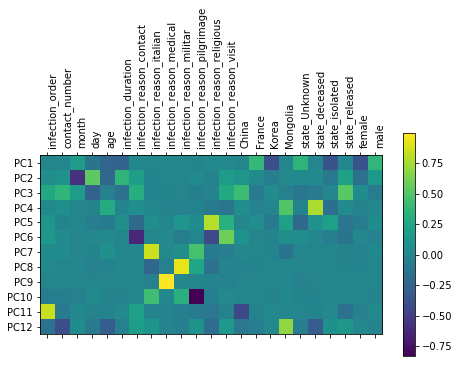

In [28]:
components_range = np.arange(1, n_components+1, 1)
components_names = list(map(lambda x: 'PC' + str(x), components_range))
plt.matshow(pcs.components_,cmap='viridis')
plt.yticks(range(0,n_components), components_names,fontsize=10)
plt.colorbar()
plt.xticks(range(0,len(features.columns)),features.columns,rotation=90,ha='left')
plt.show()

Higher values for the variables means more influence in the principal component. Lower values, means negative influence in the principal components. Thus, from the heatmap, one possible interpretation for the principal components is:
- PC1: men who is not isolated and is not from from Korea
- PC2: first months 
- PC3: state released
- PC4: state deceased
- PC5: infection reason religious
- PC6: infection reason visit
- PC7: infection reason italian
- PC8: infection reason militar
- PC9: infection reason medical
- PC10: infection reason pilgrimage
- PC11: high infection order 
- PC12: from Mongolia

## Kmeans Clustering

**K-means** tries to split the data into k groups, where the elements of a group are close to each other. 
This method is based on distance between datapoints. Therefore, the goal is to minimize the distance between the points to the centroids. 
The centroids are the "middle" points for each cluster/group. 
The algorithm starts with randomly selected centroids and in each iteration, 
it recalculates the position of the centroids. 

**Scree plot:** To determine the number of groups, a plot that shows the heights for the clusters can be used and search for the drop out point. This method is called the elbow-test. 

Now, we can create a dataframe from the principal components scores and use that for the clustering analysis. 

In [29]:
pca_df = pd.DataFrame(data = pca.fit_transform(x), columns = components_names)
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,2.424052,4.277687,1.151308,-1.509822,3.482852,5.144747,-0.432140,-0.170274,-0.246706,0.381380,-0.102455,1.128225
1,0.611904,3.849801,1.801734,0.044274,-1.523685,-5.649840,0.028122,0.056368,0.185740,0.207979,1.684324,1.727851
2,5.224868,3.434568,9.345775,-0.295189,1.468660,3.669445,-0.643746,-0.246121,-0.274986,0.407294,-2.024579,3.023083
3,3.696676,-0.307903,-0.328911,-1.624171,11.702516,-6.089520,-0.933304,-1.980368,-0.099977,-0.561258,-1.416193,-2.254403
4,1.908461,-0.978788,-0.065509,-1.694799,11.439313,-6.002573,-1.041045,-2.017262,-0.106390,-0.502815,-1.572244,-2.178969


Use the elbow test in order to define the optimal number of clusters.

In [30]:
def elbow_test(df, n_init, max_clusters, max_iter):
    distortions = []
    for i in range(1, max_clusters):
        km = KMeans(
            n_clusters=i, init='random',
            n_init=n_init, max_iter=max_iter,
            tol=1e-04, random_state=20
        )
        km.fit(df)
        distortions.append(km.inertia_)

    plt.plot(range(1, max_clusters), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()
    
    kn = KneeLocator(
        range(1, max_clusters),
        distortions,
        curve='convex',
        direction='decreasing',
        interp_method='interp1d',
    )
    return kn.knee


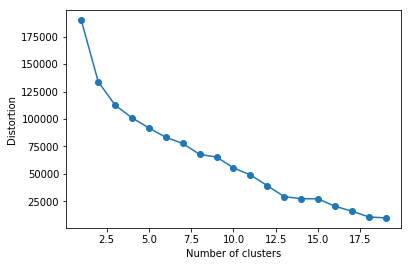

the optimal number of clusters is 4


In [31]:
n_clusters = elbow_test(pca_df, 10, 20, 300)
print(f'the optimal number of clusters is {n_clusters}')

Let's call Kmeans with the determined number of clusters and see what we find!

In [32]:
km = KMeans(n_clusters=n_clusters, random_state=20)
y = km.fit_predict(pca_df)
idx = np.argsort(km.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(n_clusters)
pca_df['cluster'] = lut[km.labels_]
df['cluster'] = lut[km.labels_]

You can save the model with the following code:   

```python
import pickle   
pickle.dump(km, open('kmeans_model.sav', 'wb'))
```


In [45]:
#To load the model
km = pickle.load(open('kmeans_model.sav', 'rb'))

We can see that clusters 3 has only 1 element. 

In [69]:
pca_df[pca_df['cluster']==3]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,cluster
173,3.025761,-1.390813,-0.64545,2.591371,7.320237,0.268957,85.79365,-22.86827,-3.815993,43.169865,-0.713433,10.56046,3


We can see that the PC7 value is high. It corresponds to the infection reason 'italian'. We can corroborate this by looking at the actual data:  

In [70]:
df[df['cluster']==3]

,sex,country,infection_reason,infection_order,contact_number,state,month,day,age,infection_duration,...,France,Korea,Mongolia,state_Unknown,state_deceased,state_isolated,state_released,female,male,cluster
174,male,France,italian,0.0,0.0,isolated,3.0,7.0,69.0,12,...,1,0,0,0,0,1,0,0,1,3


Two functions to draw graphs are defined below. One for a scatter plot to compare two principal components and see how the clusters are distributed among them. And the other to create a 3d plot to compare three principal components coloring by cluster. These graphs will help us to determine the definition of the clusters. 

In [71]:
def draw_scatter(df, col_1, col_2, cluster_column, num_clusters, title):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(col_1)
    ax.set_ylabel(col_2)
    labels = list(range(0,num_clusters))
    colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))
    axs = []
    for i in labels:
        axs.append(ax.scatter(df[df[cluster_column]==i][col_1], df[df[cluster_column]==i][col_2], cmap=colors[i]))
    
    ax.legend(axs, labels, loc='center', bbox_to_anchor=(0.92, 0.84), ncol=1)
    plt.show()


In [72]:
def create_3d_scatter(df, col_1, col_2, col_3, cluster_column, num_clusters, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    ax.set_xlabel(col_1)
    ax.set_ylabel(col_2)
    ax.set_zlabel(col_3, rotation=90)
    labels = list(range(0,num_clusters))
    colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))
    axs = []
    for i in labels:
        d = df[df[cluster_column]==i]
        axs.append(ax.scatter(d[col_1], d[col_2], d[col_3], cmap=colors[i]))
    
    ax.legend(axs, labels, bbox_to_anchor=(0.2, 0.5), ncol=1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    plt.show()

We are going to compare PC1,PC2,PC3 in a 3d plot and color by cluster to see if we find any pattern.

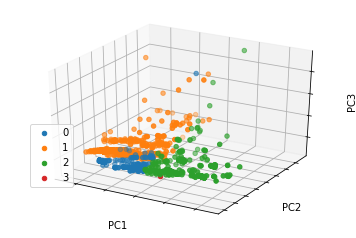

In [73]:
create_3d_scatter(pca_df, 'PC1', 'PC2', 'PC3', 'cluster', n_clusters, '')

From the graph we can see that some of the clusters are distributed according the first 2 principal components.  
 It seems that PC3 does not have too much influence in the split of the clusters. 

| Cluster | PC1  |  PC2  | PC3  |
| :------:|:----:|:-----:|:----:|
| 0       | low  |  low  | low  |
| 1       | low  |middle | -    |
| 2       | high |middle | -    |

So, let's graph other PC1 and PC2, to see more clearly this.

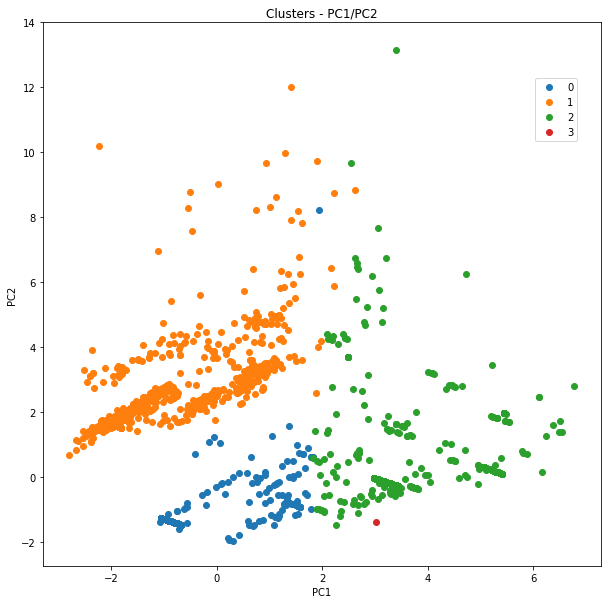

In [97]:
draw_scatter(pca_df, 'PC1', 'PC2', 'cluster', n_clusters, 'Clusters - PC1/PC2')

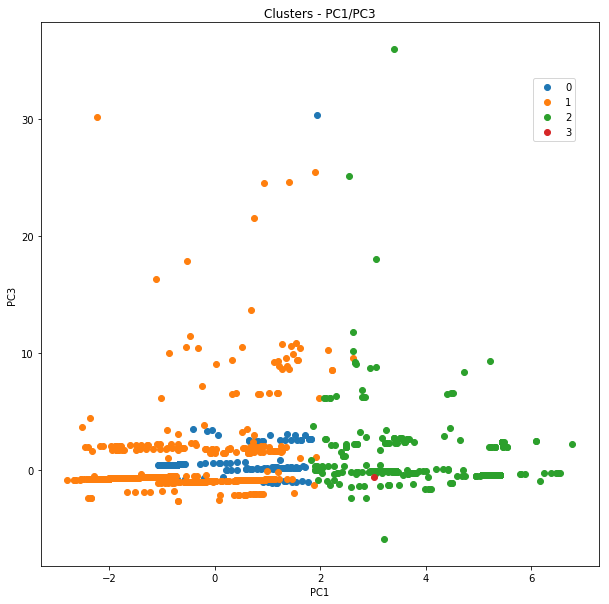

In [105]:
draw_scatter(pca_df, 'PC1', 'PC3', 'cluster', n_clusters, 'Clusters - PC1/PC3')

Remember that the meaning for the principal components was defined as follows: 
- PC1: men who is not isolated and is not from from Korea
- PC2: first months 
- PC3: state released   

So, we can conclude:    

| Cluster | Meaning                                                               |
|:-------:|:----------------------------------------------------------------------|
|    0    | mostly female from Korea - in the third month                         |
|    1    | moslty female from Korea - in the first and second months             |
|    2    | mostly men from France                                                |    

   



## Conclusion 

In summary, these are the clusters that we found:



| Cluster | Meaning                                                               |
|:-------:|:----------------------------------------------------------------------|
|    0    | mostly female from Korea - in state not released - in the third month |
|    1    | moslty female from Korea - in the first and second months             |
|    2    | mostly men from France                                                |    
|    3    | infection reason italian                                              |
